In [1]:
## Import Packages
import numpy as np
import _pickle as pk
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import os 
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

plt.rcParams['axes.xmargin'] = 0 #default margin spacing for the edges
mpl.rc('font',size=40,**{'family':'sans-serif','sans-serif':['Arial']})
%matplotlib inline

In [7]:
Source = '/Volumes/eSSD0/Papers/GMD_CanESM_p1/Data/'
mods = ['CanESM2','CanESM5_p2']

lat = np.linspace(-87.864,87.864,64)
lon = np.linspace(0,357.1875,128)

landmask_source = '/Volumes/eSSD0/Papers/GMD_CanESM_p2/Analysis/Control/'
CanESM5 = pk.load(open(landmask_source+'results/CanESM5_CCF_picon.pi','rb'))
landmask = np.isnan(CanESM5['TADV'][0,:,:])
landvalid = np.isfinite(CanESM5['TADV'][0,:,:])
landmask_ext = np.tile(landmask[None,:,:],(150,1,1))

y = lat*np.pi/180
coslat = np.cos(y)
coslat = np.tile(coslat[None,:,None],(lon.size,1,150)).T
coslat_subtrop = coslat[:,10:54,:]
coslat_trop = coslat[:,21:43,:]

SST_time = {}
SST_picon = {}
SST_picon_gam = {}
for m in range(2):
    SST_time[mods[m]] = pk.load(open(Source+mods[m]+'/Time/'+mods[m]+'_SST_x4_TmSrs.pi','rb'))
    SST_picon[mods[m]] = np.nanmean(pk.load(open(Source+mods[m]+'/Time/'+mods[m]+'_SST_picon_TmSrs.pi','rb')),axis=0)
    
SST_time['piForcing'] = pk.load(open(Source+mods[m]+'/CFMIP/Tier_2/CanESM5_p2_SST_Tmsrs.pi','rb'))

for models in SST_time.keys():

    if models == 'piForcing':
        SST_time[models][landmask_ext[:145,:,:]] = np.nan
    else:
        SST_time[models][landmask_ext] = np.nan

<ipython-input-7-3ee30cbb06d5>:24: RuntimeWarning: Mean of empty slice
  SST_picon[mods[m]] = np.nanmean(pk.load(open(Source+mods[m]+'/Time/'+mods[m]+'_SST_picon_TmSrs.pi','rb')),axis=0)


In [40]:
Response = {}
Response_gam = {}

Response['piForcing'] = np.nanmean(SST_time['piForcing'][125:],axis=0)-np.nanmean(SST_time['piForcing'][:20],axis=0)
Response['CanESM5_p2'] = np.nanmean(SST_time['CanESM5_p2'][130:],axis=0)-np.nanmean(SST_time['CanESM5_p2'][:20],axis=0)
Response['CanESM2'] = np.nanmean(SST_time['CanESM2'][130:],axis=0)-np.nanmean(SST_time['CanESM2'][:20],axis=0)


landmask_2 = np.isfinite(Response['CanESM2'])

Response_gam['piForcing'] = np.average(Response['piForcing'][landvalid],weights=coslat[0][landvalid])
Response_gam['CanESM5_p2'] = np.average(Response['CanESM5_p2'][landvalid],weights=coslat[0][landvalid])
Response_gam['CanESM2'] = np.average(Response['CanESM2'][landmask_2],weights=coslat[0][landmask_2])

<ipython-input-40-0d1adb8a0739>:4: RuntimeWarning: Mean of empty slice
  Response['piForcing'] = np.nanmean(SST_time['piForcing'][125:],axis=0)-np.nanmean(SST_time['piForcing'][:20],axis=0)
<ipython-input-40-0d1adb8a0739>:5: RuntimeWarning: Mean of empty slice
  Response['CanESM5_p2'] = np.nanmean(SST_time['CanESM5_p2'][130:],axis=0)-np.nanmean(SST_time['CanESM5_p2'][:20],axis=0)
<ipython-input-40-0d1adb8a0739>:6: RuntimeWarning: Mean of empty slice
  Response['CanESM2'] = np.nanmean(SST_time['CanESM2'][130:],axis=0)-np.nanmean(SST_time['CanESM2'][:20],axis=0)


In [43]:
SST_plot = {}
for mods in Response.keys():
    SST_plot[mods] = Response[mods]/Response_gam[mods]
    SST_plot[mods] = np.concatenate((SST_plot[mods][:,64:],SST_plot[mods][:,0:64]),axis=1)
    SST_plot[mods],lon_cyc = add_cyclic_point(SST_plot[mods],lon)

In [62]:
Response_gam

{'piForcing': 0.6042402973223451,
 'CanESM5_p2': 3.178879099527352,
 'CanESM2': 1.8641040539308316}

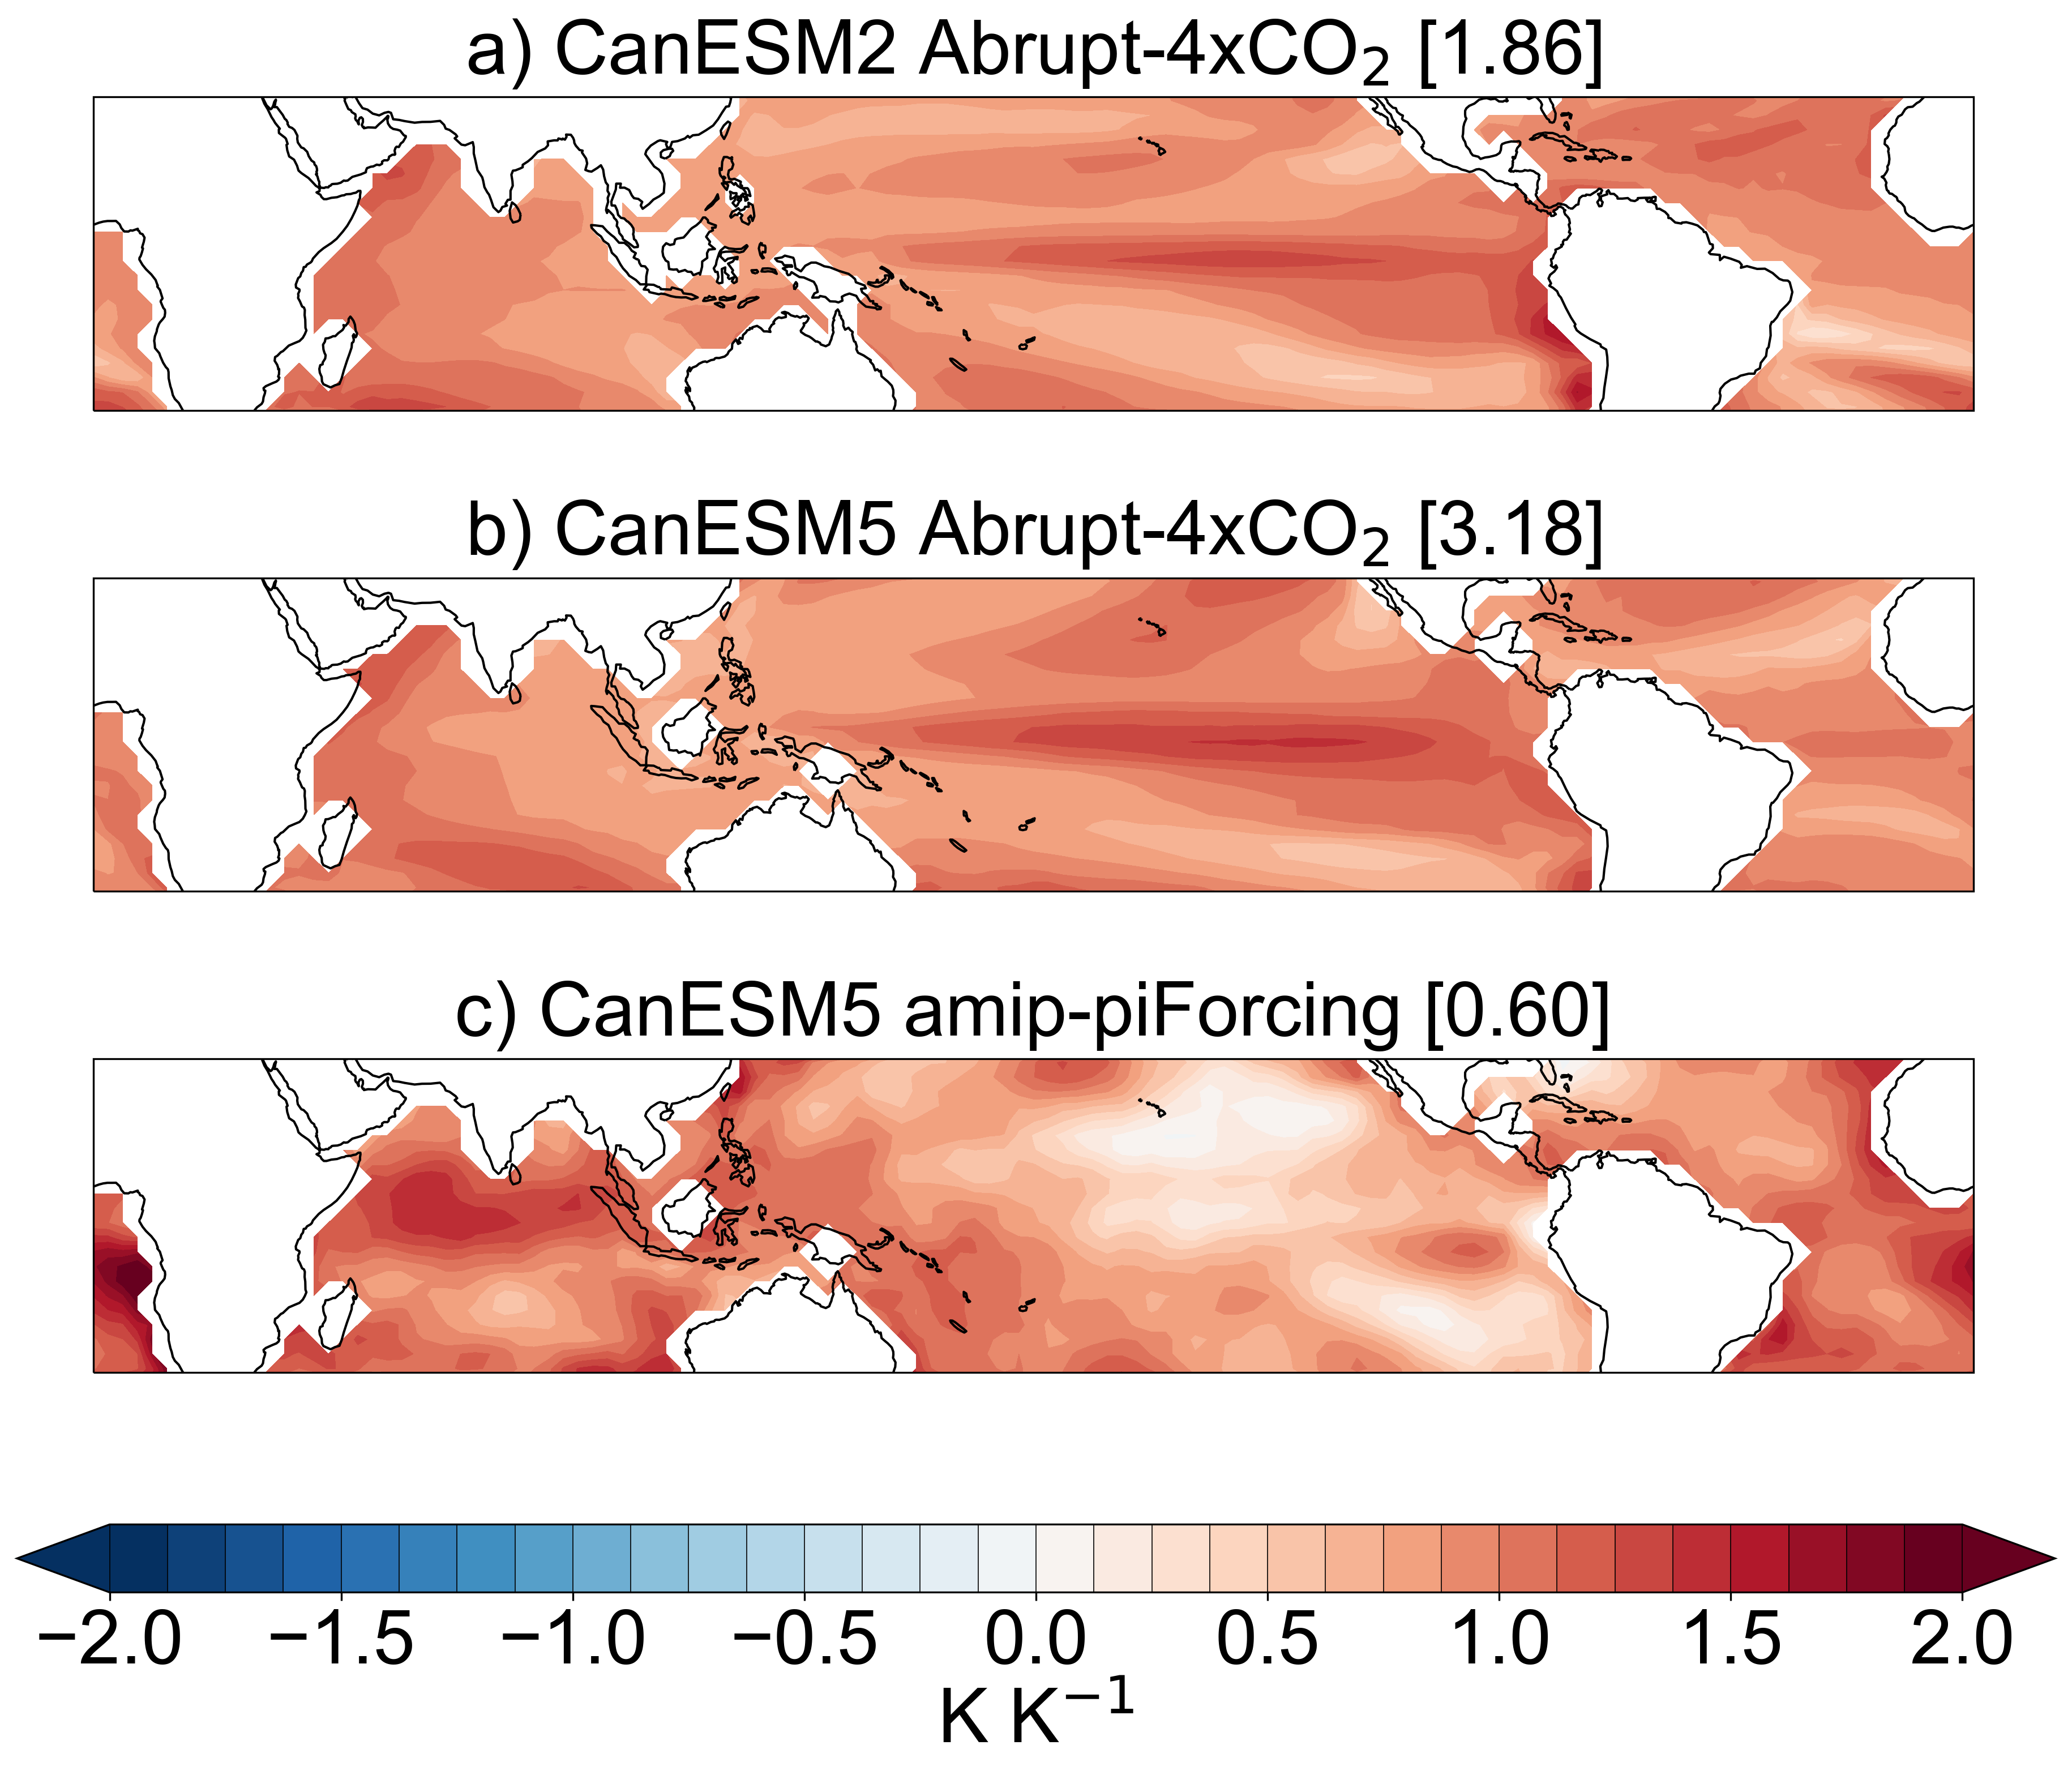

In [70]:
bounds = np.arange(-2,2.1,0.125)
bounds_ticks = np.arange(-2,2.1,0.5)
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(30,20),dpi=300)
ax = plt.subplot(3,2,1,projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([-180, 30, -30, 30], crs=ccrs.PlateCarree())
ax.set_title('a) CanESM2 Abrupt-4xCO$_{2}$ [1.86]',fontsize=32,pad=10)
im = ax.contourf(lon_cyc,lat,SST_plot['CanESM2'],bounds,cmap=cmap,norm=norm,extend='both')
ax.coastlines()

ax1 = plt.subplot(3,2,3,projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([-180, 30, -30, 30], crs=ccrs.PlateCarree())
ax1.set_title('b) CanESM5 Abrupt-4xCO$_{2}$ [3.18]',fontsize=32,pad=10)
im1 = ax1.contourf(lon_cyc,lat,SST_plot['CanESM5_p2'],bounds,cmap=cmap,norm=norm,extend='both')
ax1.coastlines()

ax2 = plt.subplot(3,2,5,projection=ccrs.PlateCarree(central_longitude=180))
ax2.set_extent([-180, 30, -30, 30], crs=ccrs.PlateCarree())
ax2.set_title('c) CanESM5 amip-piForcing [0.60]',fontsize=32,pad=10)
im2 = ax2.contourf(lon_cyc,lat,SST_plot['piForcing'],bounds,cmap=cmap,norm=norm,extend='both')
ax2.coastlines()

plt.subplots_adjust(hspace=-0.7, wspace=0.1)

cax = fig.add_axes([0.11, 0.25, 0.4, 0.02])
cbar = plt.colorbar(im,cax=cax,ticks=bounds_ticks,drawedges=True,orientation='horizontal')
cbar.set_label('K K$^{-1}$',fontsize=32)
cbar.ax.tick_params(labelsize=32)

plt.savefig('Yaaaa.png',bbox_inches='tight')